In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/net/mulan/home/huiwann/spatial/SVC/')
import tifffile
from model.train import *
from model.utils import *
import torch 
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon 

In [2]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/seqfish' 
device = 'cuda:2'

In [3]:
gene_names = np.loadtxt(f'{data_path}{dataset}/gene_names.txt', dtype=str)
gene_names = gene_names.tolist()
cell_names = np.loadtxt(f'{data_path}{dataset}/cell_names.txt', dtype=str)

test_seqfish = np.load(f"{data_path}{dataset}/test_seqfish.npz")  # 或 "cuda"
test_image = test_seqfish["data_ori"]
test_cell_morphology = test_seqfish["cell_morphology"]
test_nuclear_morphology = test_seqfish["nuclear_morphology"]
test_data_location = test_seqfish["location"]
test_cell_cycle_label = test_seqfish["identity_label"]
test_cell_cycle = test_seqfish["identity"]

test_dataset = SVC_Dataset(
    data_ori=test_image,
    location=test_data_location,
    cell_morphology_vec=test_cell_morphology,
    nuclear_morphology_vec=test_nuclear_morphology,
    identity_vec=test_cell_cycle_label,
)
print("number of testing cells:", len(test_dataset),', number of genes:', test_image.shape[1])
train_count_sum = np.load(f'{data_path}output/seqfish/train_count_sum.npy')
read_dir =f'{data_path}{dataset}/gene2vec_weight_seqfish.npy'


number of testing cells: 14 , number of genes: 1000


In [ ]:
background_pixel = torch.Tensor([[0,0],[0,1],[0,10],[0,11],[1,0],[1,11],[10,0],[10,11],[11,0],[11,1],[11,10],[11,11]]).to(device).to(torch.long)
foreground = torch.ones((12, 12), dtype=torch.bool, device=device) 
foreground[background_pixel[:, 0], background_pixel[:, 1]] = False
foreground_flat= foreground.flatten().cpu()  
foreground_expanded = foreground.reshape(1, 1, 12, 12)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, shuffle=True, random_state=2025)

groups = []
for train_index, test_index in kf.split(gene_names):
    groups.append(np.array(gene_names)[test_index])

for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

Group 1: ['Abcf2' 'Actn1' 'Aldh2' 'Anapc4' 'Atp8b2' 'Calu' 'Chd1' 'Csnk1g2'
 'Ctdsp1' 'Ddb1' 'Ehd1' 'Eif2b1' 'Eif3b' 'Fat1' 'Gtf2f1' 'Hif1a' 'Htra2'
 'Ide' 'Igf1r' 'Itgb1' 'Klhl5' 'Lasp1' 'Mical2' 'Myh10' 'Nadk' 'Ncor2'
 'Nfic' 'Nmnat2' 'Nr2f2' 'Nt5dc2' 'Pelp1' 'Pfkl' 'Phlda3' 'Polr2a'
 'Ppp2ca' 'Rbbp4' 'Rpa2' 'Slc48a1' 'Snx5' 'Sp1' 'Srrt' 'Stat3' 'Stoml2'
 'Syde1' 'Tcf19' 'Trio' 'Tspan5' 'U2af2' 'Wls' 'Ykt6']
Group 2: ['Aebp1' 'Ankrd17' 'Arhgef1' 'Asap1' 'Bag6' 'Bgn' 'Birc6' 'Ccne1'
 'Clptm1l' 'Cotl1' 'Cs' 'Cttn' 'Cyb5r3' 'Cyfip1' 'Dctn1' 'Eif6' 'Fads1'
 'Flnc' 'Gas7' 'Gtf2i' 'Kpnb1' 'Lmf2' 'Lrrc42' 'Mbtps1' 'Mvp' 'Myc'
 'Nap1l4' 'Napa' 'Nfe2l1' 'Npnt' 'Pcolce' 'Phldb2' 'Poldip2' 'Rfc1' 'Rhoq'
 'Rrn3' 'Scaf11' 'Setd5' 'Slc38a10' 'Slk' 'Smarcc1' 'Ssr3' 'Ssrp1'
 'Tagln2' 'Tbrg4' 'Tcof1' 'Tnrc18' 'Tulp4' 'Uap1' 'Ubap2l']
Group 3: ['Aacs' 'Akt1' 'Ankrd13a' 'Casp3' 'Cep170' 'Chaf1b' 'Cherp' 'Col1a1'
 'Col5a1' 'Ddx6' 'Ddx18' 'Dock1' 'Fam114a1' 'Fscn1' 'Fxr2' 'Gas1' 'Gnai3'
 'Grb10' 'Hdac3' 

In [6]:
ckpt_dir = f"{data_path}checkpoints/"
ckpt = torch.load(ckpt_dir +'SVC_seqfish.pth', map_location=device)

new_ckpt = {k.replace('module.', ''): v for k, v in ckpt['model_state_dict'].items()}

gene2vec_weight = torch.from_numpy(np.load(read_dir)).float() ##n_gene * 200
print("shape of gene2vec_weight", gene2vec_weight.shape)
# # define ViT model
model = SVC(
    gene2vec_weight = gene2vec_weight,
    cell_identity_dim = test_cell_cycle_label.shape[1],
).to(device)

model_dict = model.state_dict()
for key in model_dict:
    model_dict[key] = new_ckpt[key]
model.load_state_dict(model_dict)


shape of gene2vec_weight torch.Size([1000, 200])


<All keys matched successfully>

In [7]:
val_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False, num_workers = 4)
model.eval()
predictions_concat_mu = torch.zeros(test_image.shape).to(device) 
predictions_concat_r = torch.zeros(test_image.shape).to(device)
embeddings_concat = torch.zeros(len(test_dataset), len(gene_names), 384).to(device) 

for selected_gene in groups:

    gene_to_impute = [gene_names.index(i) for i in selected_gene if i in gene_names]
    gene_not_to_impute = [gene for gene in range(len(gene_names)) if gene not in gene_to_impute]
    gene_to_impute_name = [gene_names[i] for i in gene_to_impute]

    predictions_mu= []     
    predictions_r = []
    embeddings = []

    with torch.no_grad():
        for i, (inputs_ori, cell_morphology, nuclear_morphology, location, cell_cycle) in enumerate(val_loader, 0):

            inputs_ori = inputs_ori.to(device)           
            location = location.to(device).float()
            cell_morphology = cell_morphology.to(device).float()
            nuclear_morphology = nuclear_morphology.to(device).float()
            cell_cycle = cell_cycle.to(device).float()
            
            inputs_ori_mask = inputs_ori.clone()
            inputs_ori_mask[:,gene_to_impute] = 0

            cell_median_train = np.median((train_count_sum[:,gene_not_to_impute]).sum(axis=1))
            size_factor = (inputs_ori_mask.sum((1,2,3))/cell_median_train).unsqueeze(1).unsqueeze(2).unsqueeze(3)
            inputs = inputs_ori / size_factor  # (n_cell, n_gene, 12, 12)


            mask = torch.zeros(inputs.shape[0], inputs.shape[1]).to(device).bool()
            
            mask[:,gene_to_impute] = True
            inputs_mask = inputs.clone()
            inputs_mask[:,gene_to_impute] = 0
            embedding, predicts_mu, predicts_r= model(inputs_mask, mask, location, cell_morphology, nuclear_morphology, cell_cycle)             
            predicts_mu = predicts_mu * size_factor  # batch*gene*h*w


            predictions_mu.append(predicts_mu)
            predictions_r.append(predicts_r)
            embeddings.append(embedding)
        

            
    predictions_mu = torch.cat(predictions_mu, dim=0)
    predictions_r = torch.cat(predictions_r, dim=0)
    embeddings = torch.cat(embeddings, dim=0)

    predictions_mu[:,:,background_pixel[:,0],background_pixel[:,1]] = 0
    predictions_r[:,:,background_pixel[:,0],background_pixel[:,1]] = 0

    predictions_concat_mu[:,gene_to_impute] = predictions_mu[:,gene_to_impute]     
    predictions_concat_r[:,gene_to_impute] = predictions_r[:,gene_to_impute]
    embeddings_concat[:,gene_to_impute] = embeddings[:,gene_to_impute]


In [8]:
np.savez_compressed(f'{data_path}output/seqfish/prediction_all_genes_mu.npz', prediction=predictions_concat_mu.cpu().numpy())
np.savez_compressed(f'{data_path}output/seqfish/prediction_all_genes_r.npz', prediction=predictions_concat_r.cpu().numpy())

In [35]:
## define similarity map of 49 well-annotated genes
test_count_sum  = test_image.sum(axis=(-1,-2))
embeddings_np = embeddings_concat.cpu().numpy()

# Compute pairwise distances between gene embeddings for each cell
num_cells, num_genes, embedding_dim = embeddings_np.shape
gene_interested = gene_names
print("gene_interested:",len(gene_interested))
gene_idx = [gene_names.index(i)  for i in gene_interested]
embeddings_np_interested = embeddings_np[:, gene_idx]
most_similar_genes_all_cells = {gene: [] for gene in gene_interested}
### calculate the count of cells which consider gene A as the 10 nearest neighbors in embedding space of gene B
knn_gene_distance = np.zeros((len(gene_interested),2))
for cell in tqdm(range(num_cells)):
    # Compute pairwise distances for the current cell
    distances = cdist(embeddings_np_interested[cell], embeddings_np[cell], metric='cosine')
    
    # Identify the most similar genes for each gene of interest in the current cell
    idx = 0 
    for gene in gene_interested:
        if test_count_sum[cell][idx] != 0:
            knn_gene_distance[idx][0]+=(np.sort(distances[idx])[1:11]).mean()
            knn_gene_distance[idx][1]+=1
        idx += 1
knn_gene_distance_avg = knn_gene_distance[:,0]/knn_gene_distance[:,1]

gene_interested: 1000


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


In [36]:
avg_pcc_svc = []
foreground_pixels = (foreground==True).sum().item()  
for i in tqdm(range(len(gene_names))):
    
    pred_i = predictions_concat_mu[:,i].cpu().numpy()
    truth_i = test_image[:,i]
  
    non_zero_image = truth_i.sum((-1,-2))!=0
  
    pred_i_flat, truth_i_flat = pred_i.reshape(pred_i.shape[0],-1), truth_i.reshape(truth_i.shape[0],-1)

    pcc_svc_per_gene = []
    for j in range(truth_i.shape[0]):
        if non_zero_image[j]:
            pcc_svc_per_gene.append(np.corrcoef(pred_i_flat[j], truth_i_flat[j])[0,1])

    avg_pcc_svc.append(np.array(pcc_svc_per_gene).mean())

avg_pcc_svc = np.array(avg_pcc_svc)
print("avg_pcc_svc:",np.round(avg_pcc_svc.mean(), 4))### gene求平均


100%|██████████| 1000/1000 [00:00<00:00, 2121.67it/s]

avg_pcc_svc: 0.3148


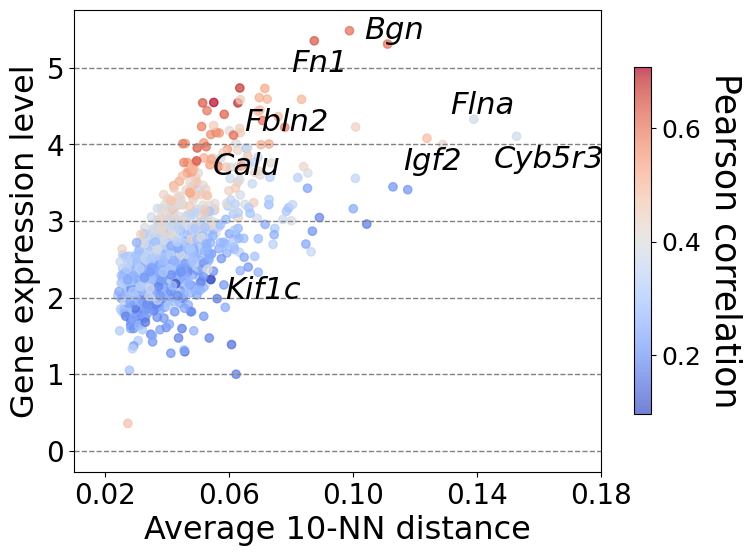

In [23]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8.5, 6))
exp_level = test_image.sum((2,3)).mean(0)
plt.scatter(knn_gene_distance_avg, np.log1p(exp_level), alpha=0.7,c = avg_pcc_svc,cmap = 'coolwarm')
cbar = plt.colorbar(shrink=0.75)
cbar.ax.tick_params(labelsize=18)

cbar.set_label('Pearson correlation', fontsize=25, rotation=270,labelpad=30)#, rotation=0, fontsize=15,labelpad=-30)#,fontweight='bold'
cbar_ax = cbar.ax
text_obj = cbar_ax.get_yaxis().get_label()
text_obj.set_position((0.2, 0.5))

plt.xticks(fontsize=20)
plt.xlabel('Average 10-NN distance',fontsize=23)
plt.yticks(fontsize=20) 
plt.ylabel('Gene expression level',fontsize=23)
for i in range(6):
    plt.axhline(y=i, color='gray', linestyle='--',linewidth=1)  

### xlim
plt.xlim(0.01, 0.18)
plt.xticks([0.02,0.06,0.10,0.14,0.18])

for gene in gene_names:     
    if gene in ['Cyb5r3','Igf2','Calu','Kif1c','Fbln2','Fn1']:
        plt.annotate(gene.capitalize(), (knn_gene_distance_avg[gene_names.index(gene)]-0.012,np.log1p(exp_level)[gene_names.index(gene)]-0.3), textcoords="offset points", xytext=(10,-6), ha='left', fontsize=22, fontstyle="italic")
    elif gene in ['Flna','Bgn']:         
        plt.annotate(gene.capitalize(), (knn_gene_distance_avg[gene_names.index(gene)]-0.012,np.log1p(exp_level)[gene_names.index(gene)]+0.18), textcoords="offset points", xytext=(10,-6), ha='left', fontsize=22, fontstyle="italic")
plt.show()

### focus on the 49 well-annotated genes

In [38]:
# seqfish+ genes in extended data fig 3
protrusionList = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Kif1c', 'Kctd10', 
                    'Dynll2', 'Arhgap11a', 'Dync1li2', 'Palld', 'Naa50']

nuclearList = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn',  
                 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1',
                 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6',
                 'Col5a2', 'Itgb1', 'Calu', 'Pdia3']
                 
cytoplasmList = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1',
                   'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 
                   'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1',
                   'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']

In [37]:
selected_gene = protrusionList+nuclearList+cytoplasmList
selected_gene_idx = [gene_names.index(i) for i in selected_gene]
print("gene to impute:",selected_gene_idx)
prediction_impute_mu = predictions_concat_mu[:,selected_gene_idx]
prediction_impute_r = predictions_concat_r[:,selected_gene_idx]
# np.savez_compressed(f'{data_path}output/seqfish/prediction_49_genes_mu.npz', prediction=prediction_impute_mu.cpu().numpy())
# np.savez_compressed(f'{data_path}output/seqfish/prediction_49_genes_r.npz', prediction=prediction_impute_r.cpu().numpy())

gene to impute: [204, 779, 219, 424, 419, 251, 64, 250, 588, 524, 169, 321, 301, 175, 93, 548, 446, 584, 25, 281, 172, 757, 637, 170, 603, 173, 413, 109, 601, 217, 518, 14, 866, 430, 376, 641, 378, 592, 865, 325, 665, 108, 821, 935, 379, 112, 846, 947, 114]


In [39]:
prediction_gene_ratio = np.zeros((len(test_dataset),len(selected_gene_idx)))
truth_gene_ratio = np.zeros((len(test_dataset),len(selected_gene_idx)))
I = 0
for cell in range(len(test_dataset)):
    cell_gene_pred = predictions_concat_mu[cell].cpu().numpy()
    cell_gene_real = test_image[cell]
    J = 0
    for gene in selected_gene_idx:
        heatmap_pred = cell_gene_pred[gene,:,:,]  
        heatmap_real = cell_gene_real[gene,:,:,]
        total_sum_pred = np.sum(heatmap_pred)
        total_sum_real = np.sum(heatmap_real)
        if total_sum_pred != 0:
            ratio_pred = 0
            for i in range(heatmap_pred.shape[0]):
                for j in range(heatmap_pred.shape[1]):
                    ratio_pred += np.sqrt((i+0.5-6)**2 + (j+0.5-6)**2)/6 * heatmap_pred[i, j]

            ratio_pred /= total_sum_pred
            ratio_pred = np.min([ratio_pred,1])
            prediction_gene_ratio[I,J] = ratio_pred

        if total_sum_real != 0:
            ratio_real = 0
            for i in range(heatmap_real.shape[0]):
                for j in range(heatmap_real.shape[1]):
                    ratio_real += np.sqrt((i+0.5-6)**2 + (j+0.5-6)**2)/6 * heatmap_real[i, j]
 
            ratio_real /= total_sum_real
            ratio_real = np.min([ratio_real,1])
            truth_gene_ratio[I,J] = ratio_real

        J += 1
    I += 1

In [14]:
gene_to_impute_type = []
for i in selected_gene:
    if i in protrusionList:
        gene_to_impute_type.append('Protrusion')
    elif i in cytoplasmList:
        gene_to_impute_type.append('Cytoplasm')
    else:
        gene_to_impute_type.append('Nuclear/Perinuclear')
gene_to_impute_type_dict = {'Protrusion':1,'Cytoplasm':2,'Nuclear/Perinuclear':3}
gene_to_impute_type_num = np.array([gene_to_impute_type_dict[i] for i in gene_to_impute_type])

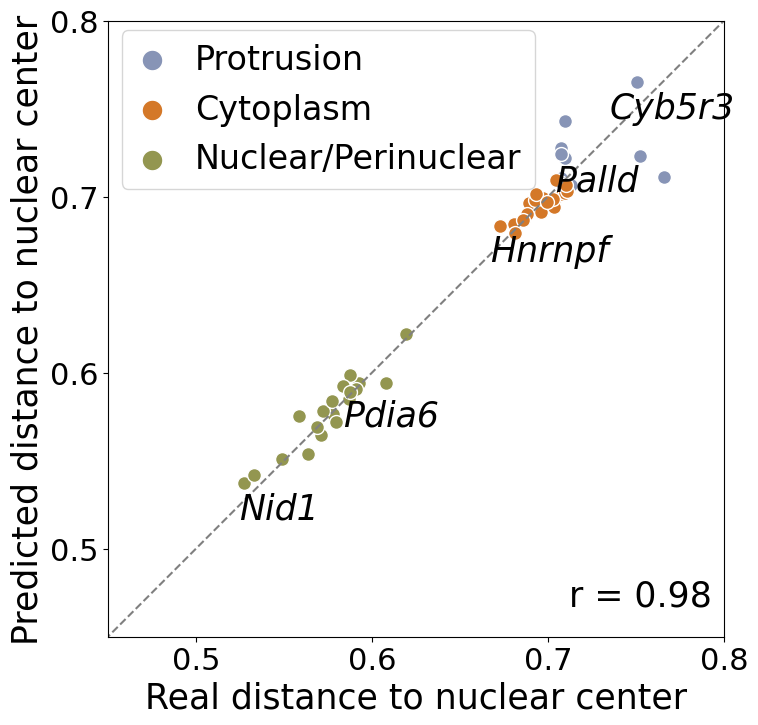

In [42]:
prediction_gene_ratio_mean = np.sum(prediction_gene_ratio,axis=0)
prediction_gene_ratio_mean = prediction_gene_ratio_mean/np.sum(prediction_gene_ratio!=0,axis=0)
prediction_gene_ratio_mean = np.array(prediction_gene_ratio_mean).reshape(-1,1)
truth_gene_ratio_mean =  np.sum(truth_gene_ratio,axis=0)
truth_gene_ratio_mean = truth_gene_ratio_mean/np.sum(truth_gene_ratio!=0,axis=0)
truth_gene_ratio_mean = np.array(truth_gene_ratio_mean).reshape(-1,1)
impute_real_concat = np.concatenate((truth_gene_ratio_mean,prediction_gene_ratio_mean), axis=1)

gene1 ='Nid1'
gene2='Pdia6'
gene3="Hnrnpf"
gene4="Palld"
gene5="Cyb5r3"
representative_genes = [gene1, gene2, gene3, gene4, gene5]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = prediction_gene_ratio_mean
custom_colors = ["#8794b6","#d47828","#939650"] 
i=0
for type in gene_to_impute_type_dict:
    ax.scatter(impute_real_concat[np.array(gene_to_impute_type) == type,0], impute_real_concat[np.array(gene_to_impute_type) == type,1],c=custom_colors[i],s=100,label=type,edgecolor='white')
    i+=1
ax.legend(title='',fontsize=24,bbox_to_anchor=(0.72, 0.7),markerscale=1.5,handlelength=1)
ax.text(0.98, 0.05, f'r = {np.corrcoef(impute_real_concat[:,0], impute_real_concat[:,1])[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
for gene in selected_gene:
    if gene in representative_genes:
        ax.annotate(gene, (impute_real_concat[selected_gene.index(gene),0]+0.02, impute_real_concat[selected_gene.index(gene),1]-0.001), textcoords="offset points", xytext=(0,-25), ha='center', fontsize=25,fontstyle="italic")
ax.set_aspect('equal')
ax.plot([0, 0.8], [0, 0.8], '--', color='gray')
ax.set_xlim(0.45, 0.8)
ax.set_ylim(0.45, 0.8)
ax.set_xticks([0.5,0.6,0.7,0.8])
ax.set_xticklabels([0.5,0.6,0.7,0.8],fontsize=22)
ax.set_yticks([0.5,0.6,0.7,0.8])
ax.set_yticklabels([0.5,0.6,0.7,0.8],fontsize=22)
ax.set_xlabel('Real distance to nuclear center', fontsize=25)
ax.set_ylabel('Predicted distance to nuclear center', fontsize=25)
plt.show()

In [40]:
import seaborn as sns
_, p_1 = wilcoxon(prediction_gene_ratio[:,selected_gene.index(gene1)], truth_gene_ratio[:,selected_gene.index(gene1)], alternative='two-sided') 
print(p_1) 
_, p_2 = wilcoxon(prediction_gene_ratio[:,selected_gene.index(gene2)], truth_gene_ratio[:,selected_gene.index(gene2)], alternative='two-sided') 
print(p_2)
_, p_3 = wilcoxon(prediction_gene_ratio[:,selected_gene.index(gene3)], truth_gene_ratio[:,selected_gene.index(gene3)], alternative='two-sided')
print(p_3)
_, p_4 = wilcoxon(prediction_gene_ratio[:,selected_gene.index(gene4)], truth_gene_ratio[:,selected_gene.index(gene4)], alternative='two-sided')
print(p_4)
_, p_5 = wilcoxon(prediction_gene_ratio[:,selected_gene.index(gene5)], truth_gene_ratio[:,selected_gene.index(gene5)], alternative='two-sided')
print(p_5)


0.42626953125
1.0
0.71484375
0.5416259765625
0.3575439453125


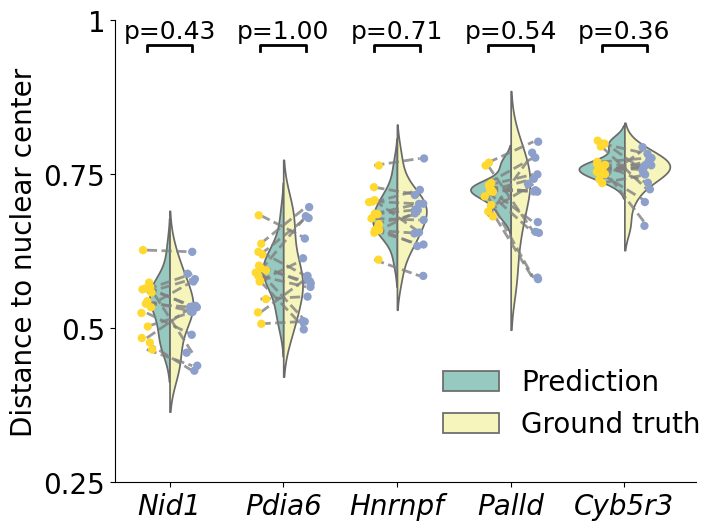

: 

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(7.5, 6))
n = len(test_dataset)
cells = np.arange(n)

dfs = []
for g in representative_genes:
    idx = selected_gene.index(g)

    df_g = pd.DataFrame({
        "Group":    [g] * (2 * n),                           
        "Subgroup": np.repeat(["Prediction", "Ground truth"], n),
        "Value":    np.concatenate([
                        prediction_gene_ratio[:, idx],       
                        truth_gene_ratio[:, idx],           
                    ], axis=0),
        "Cell":     np.tile(cells, 2),
    })
    dfs.append(df_g)

df = pd.concat(dfs, ignore_index=True)
sns.violinplot(x="Group", y="Value", hue="Subgroup", data=df,
               split=True, inner=None, palette="Set3")
ax = sns.stripplot(x='Group', y='Value', hue='Subgroup', data=df, palette='Set2_r', edgecolor="gray", dodge=True,legend=False, size=6)

group_centers = {group.get_text(): idx for idx, group in enumerate(ax.get_xticklabels())}
dodge_offset = 0.2 

y_max = 1  
y_offset_intra = 0.01 
y_offset_inter = 0.05 
star_offset = 0.03  
fontprops = {'size': 18, 'ha': 'center'}


ax.plot([-0.2, -0.2,0.2,0.2], 
        [y_max - y_offset_inter,y_max - y_offset_inter+0.01,y_max - y_offset_inter+0.01, y_max - y_offset_inter], 
        color='black', lw=2, clip_on=False)
ax.text(0, y_max - y_offset_inter + 0.02, 
        f"p={np.round(p_1, 2):.2f}", 
        **fontprops)

ax.plot([0.8, 0.8,1.2,1.2], 
        [y_max - y_offset_inter,y_max - y_offset_inter+0.01,y_max - y_offset_inter+0.01, y_max - y_offset_inter], 
        color='black', lw=2, clip_on=False)
ax.text(1, y_max - y_offset_inter + 0.02, 
        f"p={np.round(p_2, 2):.2f}", 
        **fontprops)

ax.plot([1.8, 1.8,2.2,2.2], 
        [y_max - y_offset_inter,y_max - y_offset_inter+0.01,y_max - y_offset_inter+0.01, y_max - y_offset_inter], 
        color='black', lw=2, clip_on=False)
ax.text(2, y_max - y_offset_inter + 0.02, 
        f"p={np.round(p_3, 2):.2f}", 
        **fontprops)

ax.plot([2.8, 2.8,3.2,3.2], 
        [y_max - y_offset_inter,y_max - y_offset_inter+0.01,y_max - y_offset_inter+0.01, y_max - y_offset_inter], 
        color='black', lw=2, clip_on=False)
ax.text(3, y_max - y_offset_inter + 0.02, 
        f"p={np.round(p_4, 2):.2f}", 
        **fontprops)

ax.plot([3.8, 3.8,4.2,4.2], 
        [y_max - y_offset_inter,y_max - y_offset_inter+0.01,y_max - y_offset_inter+0.01, y_max - y_offset_inter], 
        color='black', lw=2, clip_on=False)
ax.text(4, y_max - y_offset_inter + 0.02, 
        f"p={np.round(p_5, 2):.2f}", 
        **fontprops)

for gene in df['Group'].unique():
    gene_data = df[df['Group'] == gene]
    for cell in gene_data['Cell'].unique():
        cell_data = gene_data[gene_data['Cell'] == cell]
        for group in representative_genes:
            group_data = cell_data[cell_data['Group'] == group]
            if len(group_data) == 2:
                x_x = group_centers[group] - dodge_offset  
                x_y = group_centers[group] + dodge_offset
                y_x = group_data[group_data['Subgroup'] == 'Prediction']['Value'].values[0]
                y_y = group_data[group_data['Subgroup'] == 'Ground truth']['Value'].values[0]
                ax.plot([x_x, x_y], [y_x, y_y], color='gray', linestyle='--', alpha=0.8,lw=2)
ax.set_ylim(0.25,1)
ax.legend(title='',fontsize=20,bbox_to_anchor=(1.05, 0.3),frameon=False)
ax.set_xlabel('')
ax.set_xticklabels(representative_genes,fontsize=20, fontstyle="italic")
ax.set_ylabel('Distance to nuclear center',fontsize=20)
ax.set_yticks([0.25,0.5,0.75,1])
ax.set_yticklabels([0.25,0.5,0.75,1],fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()